In [10]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
import os
import zipfile
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [9]:
# (Unzip the Dataset)
zip_path = '/content/drive/MyDrive/DBU Project/food-fresh-dataset.zip'
extract_path = '/content'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

    print("Dataset successfully extracted ")


Dataset successfully extracted 


In [12]:

if os.path.exists('/content/dataset/train'):
    print("Train and Test folders found successfully!")
else:
    print("ERROR: Could not find train/test folders after extraction.")

Train and Test folders found successfully!


In [13]:
base_dir = '/content/dataset'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

IMG_SIZE = (224, 224)
BATCH_SIZE = 32

In [14]:
# 2.3. ImageDataGenerator መፍጠር
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [15]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

Found 10901 images belonging to 6 classes.
Found 2698 images belonging to 6 classes.


In [16]:
# 3.1. ዝግጁ የሆነውን MobileNetV2 ሞዴል መጫን
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False # ንብርብሮቹን እንዳይሰለጥኑ ማድረግ

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [17]:
# 3.2. የራሳችንን የምደባ ንብርብሮች መጨመር
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
num_classes = train_generator.num_classes
outputs = Dense(num_classes, activation='softmax')(x)

In [18]:
# 3.3. አዲሱን ሞዴል መገንባት እና ማጠናቀር
model = Model(inputs=base_model.input, outputs=outputs)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# 3.4. የሞዴሉን አወቃቀር ማየት
model.summary()

In [20]:
# train model

# Epochs -> ሞዴሉ ሙሉውን ዳታ ስንት ጊዜ እያየ እንዲሰለጥን እንደምንፈልግ ይወስናል
EPOCHS = 2

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
341/341 ━━━━━━━━━━━━━━━━━━━━ 951s 3s/step - accuracy: 0.8882 - loss: 0.3230 - val_accuracy: 0.9692 - val_loss: 0.0796
Epoch 2/2
341/341 ━━━━━━━━━━━━━━━━━━━━ 885s 3s/step - accuracy: 0.9673 - loss: 0.0875 - val_accuracy: 0.9792 - val_loss: 0.0528


In [21]:
# ክፍል 5: ውጤቶችን መገምገም እና በምስል ማሳየት (Evaluation and Visualization)
import matplotlib.pyplot as plt
# 5.1. ከስልጠናው የተገኙ ውጤቶችን ማውጣት
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

Text(0, 0.5, 'Accuracy')

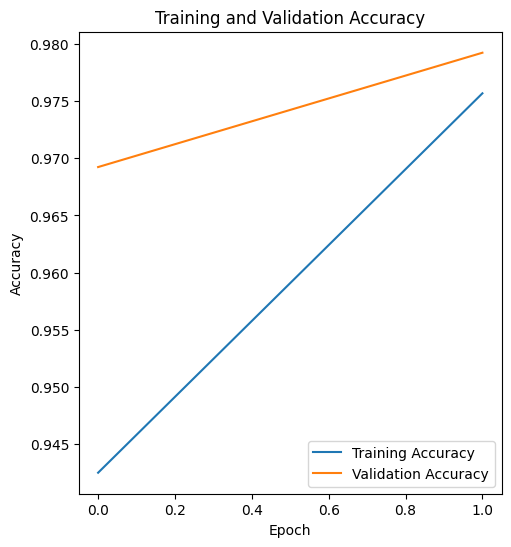

In [22]:
# 5.2. የትክክለኛነት (Accuracy) ግራፍ መስራት
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

Text(0, 0.5, 'Loss')

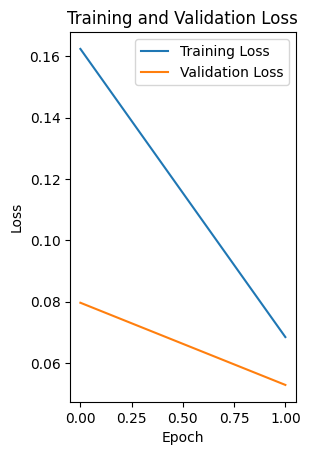

In [23]:
# 5.3. የስህተት (Loss) ግራፍ መስራት
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

In [24]:

plt.show()

In [25]:
final_val_accuracy = val_acc[-1] * 100
print(f"Final Validation Accuracy: {final_val_accuracy:.2f}%")

Final Validation Accuracy: 97.92%


In [26]:
import numpy as np
from sklearn.metrics import classification_report

# 1. Get predictions from the model on the test data
Y_pred = model.predict(test_generator)
y_pred = np.argmax(Y_pred, axis=1)

# 2. Get the true labels
y_true = test_generator.classes

# 3. Print the classification report
print('Classification Report')
print(classification_report(y_true, y_pred, target_names=list(test_generator.class_indices.keys())))

85/85 ━━━━━━━━━━━━━━━━━━━━ 161s 2s/step
Classification Report
               precision    recall  f1-score   support

  freshapples       0.10      0.11      0.11       395
  freshbanana       0.14      0.14      0.14       381
 freshoranges       0.15      0.14      0.15       388
 rottenapples       0.21      0.21      0.21       601
 rottenbanana       0.18      0.18      0.18       530
rottenoranges       0.16      0.16      0.16       403

     accuracy                           0.16      2698
    macro avg       0.16      0.16      0.16      2698
 weighted avg       0.16      0.16      0.16      2698



In [28]:

#Gradio
#ክፍል 7: የሰለጠነውን ሞዴል ማስቀመጥ (Save the Trained Model)


# ሞዴሉን የምናስቀምጥበትን ዱካ መወሰን (በ Google Drive ላይ)
model_save_path = '/content/drive/MyDrive/DBU Project/food_classifier_model.h5'

# ሞዴሉን ማስቀመጥ
model.save(model_save_path)

print(f"Model successfully saved to: {model_save_path}")

Model successfully saved to: /content/drive/MyDrive/DBU Project/food_classifier_model.h5
